# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

from scipy.stats import yulesimon

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Conv1D, Flatten
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2, l1_l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
RANDOM_STATE = 17
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=RANDOM_STATE)


# Generate data
### &nbsp;&nbsp; *num_alphas*: number of alphas generated between (min_alpha) and (max_alpha) inclusive
### &nbsp;&nbsp; *samples_per_alpha*: number of samples (rows) for each alpha 
### &nbsp;&nbsp; *N* : number of random variates (number of samples drawn from yulesimon distribution)
### &nbsp;&nbsp; *M* : maximun value of random variates (length of input vectors == number of features)

In [2]:
def generate_data(num_alphas, samples_per_alpha, N, min_alpha=2.01, max_alpha=3.00, random_state=0):
    '''
    params:
        num_alphas: number of alphas generated between (min_alpha) and (max_alpha) inclusive
        samples_per_alpha: number of samples (rows) for each alpha 
        N: number of RV samples (columns) per row
    '''

    # fix loc at zero
    loc = 0

    X = np.empty((num_alphas * samples_per_alpha, N+1), float)

    row = 0
    for alpha in np.linspace(min_alpha, max_alpha, num=num_alphas):
        
        # generate samples (rows) for current alpha
        for i in range(samples_per_alpha):
            X[row, 0] = alpha
            X[row, 1:] = yulesimon.rvs(alpha, loc=loc, size=N, random_state=random_state)
            row += 1

    #lilo
    # suffle rows
    np.random.shuffle(X)

    # separate X from y
    y = X[:, 0]
    X = X[:, 1:].astype(int)

    # create a histogram (H) from (X) rows
    nbins = np.max(X)
    H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

    # log scale (H) rows
    logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)

    return logH, y, nbins # (nbins == M)

# Create Model

In [3]:
def create_model(n_features, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    model.add(Conv1D(32, 2, activation="relu", input_shape=(n_features,1)))
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    return model


# Training

In [4]:
def train(X_train, y_train, X_val, y_val, batch_size=8):
    model = create_model(X_train.shape[1], 
                         activation='relu', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=True, 
                         dropout=0.0, 
                         optimizer=Adam(lr=1e-2), 
                         k_reg=True, 
                         k_reg_lr=1e-5, 
                         a_reg=True, 
                         a_reg_lr=1e-5)
    
    # early-stopping
    es_patience = 50
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=0)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    base_path       = 'models/yulesimon_{}'.format(date_str)
    model_path      = '{}.h5'.format(base_path)
    history_path    = '{}.history'.format(base_path)
    
    cp = ModelCheckpoint(
        filepath=model_path, 
        monitor='val_loss', 
        mode='min', 
        save_best_only=True, 
        verbose=0)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=1000, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        callbacks=[es, reduce_lr, cp], 
                        verbose=0)
    
    # save history with model
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)
    
    # load best weights from last checkpoint
    model = keras.models.load_model(model_path)
    return model, history.history

In [5]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    # plt.figure(figsize=(2,2))
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    print('loss:', np.min(history['loss']))
    print('val_loss:', np.min(history['val_loss']))    

# Trials

In [6]:
X, y, M = generate_data(
    num_alphas=100, 
    samples_per_alpha=50, 
    N=2**15, 
    random_state=RANDOM_STATE)
print("M: {}".format(M))

# reshape X for Conv1D
X = X.reshape(X.shape[0], X.shape[1], 1)

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.25, 
    random_state=RANDOM_STATE)

# split train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, 
    random_state=RANDOM_STATE)

# training
model, history = train(X_train, y_train, X_val, y_val)


M: 251


In [7]:
# evaluate
print('model.evaluate(X_train, y_train)')
print(model.evaluate(X_train, y_train))

print('model.evaluate(X_val, y_val)')
print(model.evaluate(X_val, y_val))

print('model.evaluate(X_test, y_test)')
print(model.evaluate(X_test, y_test))

y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print("MSE: {}".format(mse))

sqrt_mse = np.sqrt(mse)
print("sqrt_mse: {}".format(sqrt_mse))


model.evaluate(X_train, y_train)
88/88 [==============================] - 0s 3ms/step - loss: 4.8191e-08
4.819139931555583e-08
model.evaluate(X_val, y_val)
30/30 [==============================] - 0s 4ms/step - loss: 4.8848e-08
4.8848459499595265e-08
model.evaluate(X_test, y_test)
40/40 [==============================] - 0s 3ms/step - loss: 5.6237e-08
5.6237460910324444e-08
MSE: 5.6238373957739896e-08
sqrt_mse: 0.00023714631970506161


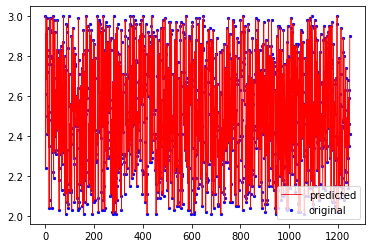

In [8]:
x_ax = range(len(y_pred))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()


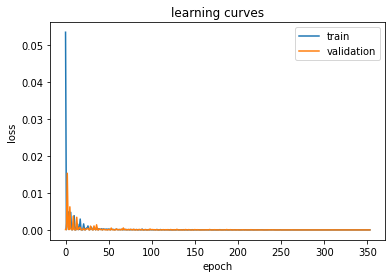

loss: 2.4566096712419494e-08
val_loss: 4.884898530121973e-08


In [9]:
plot_learning_curves(history, train_key='loss', val_key='val_loss')